# Kaggle竞赛 —— 泰坦尼克号（Titanic）

本篇是kaggle竞赛中的一道练习题  
https://www.kaggle.com/c/titanic

## 一. 导入数据包与数据集

In [81]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

train=pd.read_csv('/opt/train.csv')
test=pd.read_csv('/opt/test.csv')
PassengerId=test['PassengerId']
all_data = pd.concat([train, test], ignore_index = True)

## 二. 数据分析

### 1.总体预览

In [15]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


•PassengerID（ID）  
•Survived(存活与否)  
•Pclass（客舱等级，较为重要）  
•Name（姓名，可提取出更多信息）  
•Sex（性别，较为重要）  
•Age（年龄，较为重要）  
•Parch（直系亲友）  
•SibSp（旁系）  
•Ticket（票编号）  
•Fare（票价）  
•Cabin（客舱编号）  
•Embarked（上船的港口编号）  

In [82]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


从上面的数据我们可以发现有的特征是有空值的

### 2.数据初步分析(使用统计学与绘图)  

目的:初步了解数据之间的相关性,为构造特征工程以及模型建立做准备  

In [16]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

#### 1)Sex Feature：女性幸存率远高于男性

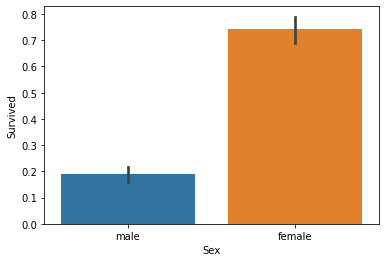

In [33]:
sns.barplot(x="Sex", y="Survived", data=train)

#### 2)Pclass Feature：乘客社会等级越高，幸存率越高

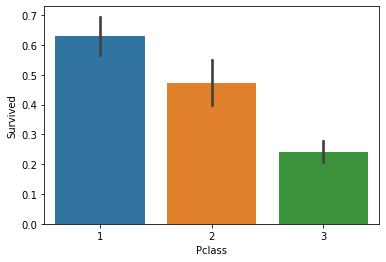

In [34]:
sns.barplot(x="Pclass", y="Survived", data=train)

#### 3)SibSp Feature：配偶及兄弟姐妹数适中的乘客幸存率更高

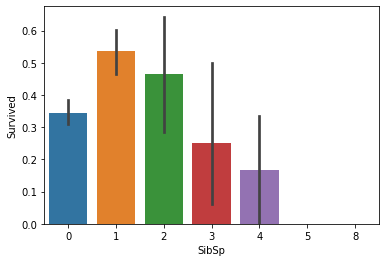

In [35]:
sns.barplot(x="SibSp", y="Survived", data=train)

#### 4)Parch Feature：父母与子女数适中的乘客幸存率更高

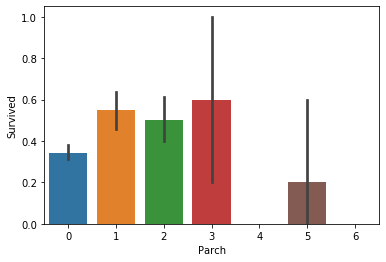

In [36]:
sns.barplot(x="Parch", y="Survived", data=train)

#### 5)从不同生还情况的密度图可以看出，在年龄15岁的左侧，生还率有明显差别，密度图非交叉区域面积非常大，但在其他年龄段，则差别不是很明显，认为是随机所致，因此可以考虑将此年龄偏小的区域分离出来。

Text(12.389771412037035, 0.5, 'density')

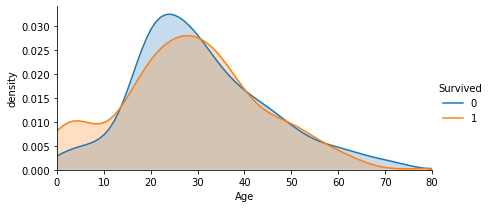

In [37]:
facet = sns.FacetGrid(train, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.xlabel('Age') 
plt.ylabel('density')

#### 6)Embarked登港港口与生存情况的分析
结果分析:C地的生存率更高,这个也应该保留为模型特征.

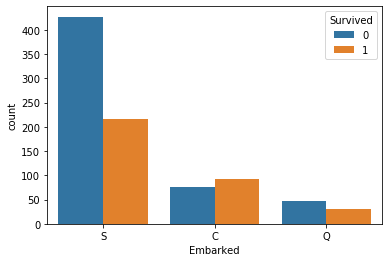

In [38]:
sns.countplot('Embarked',hue='Survived',data=train)

#### 7)Title Feature(New)：不同称呼的乘客幸存率不同
新增Title特征，从姓名中提取乘客的称呼，归纳为六类。

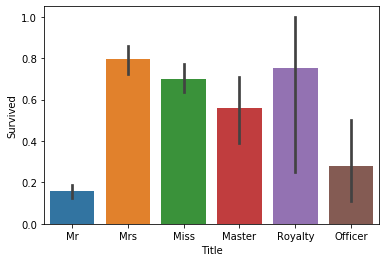

In [39]:
all_data['Title'] = all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))

all_data['Title'] = all_data['Title'].map(Title_Dict)
sns.barplot(x="Title", y="Survived", data=all_data)

#### 8)FamilyLabel Feature(New)：家庭人数为2到4的乘客幸存率较高
新增FamilyLabel特征，先计算FamilySize=Parch+SibSp+1，然后把FamilySize分为三类。

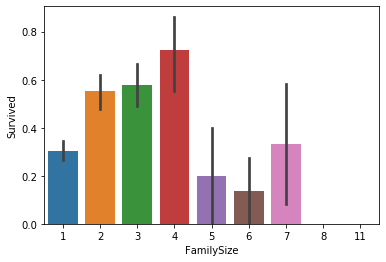

In [40]:
all_data['FamilySize']=all_data['SibSp']+all_data['Parch']+1
sns.barplot(x="FamilySize", y="Survived", data=all_data)

按生存率把FamilySize分为三类，构成FamilyLabel特征。

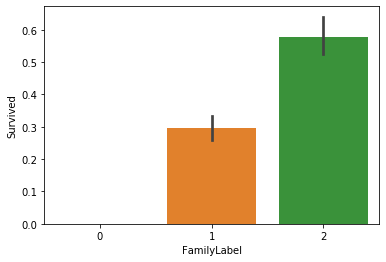

In [41]:
def Fam_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
all_data['FamilyLabel']=all_data['FamilySize'].apply(Fam_label)
sns.barplot(x="FamilyLabel", y="Survived", data=all_data)

#### 9)Deck Feature(New)：不同甲板的乘客幸存率不同
新增Deck特征，先把Cabin空缺值填充为'Unknown'，再提取Cabin中的首字母构成乘客的甲板号。

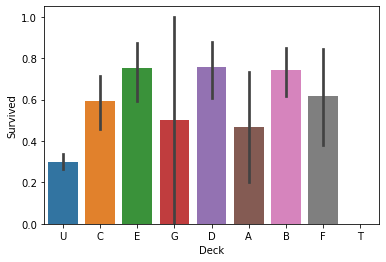

In [42]:
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')
all_data['Deck']=all_data['Cabin'].str.get(0)
sns.barplot(x="Deck", y="Survived", data=all_data)

#### 10)TicketGroup Feature(New)：与2至4人共票号的乘客幸存率较高
新增TicketGroup特征，统计每个乘客的共票号数。

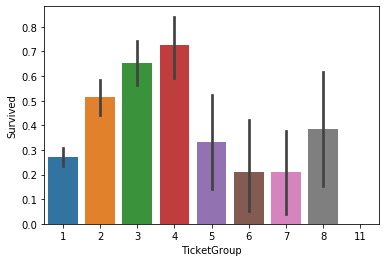

In [43]:
Ticket_Count = dict(all_data['Ticket'].value_counts())
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x:Ticket_Count[x])
sns.barplot(x='TicketGroup', y='Survived', data=all_data)

按生存率把TicketGroup分为三类。

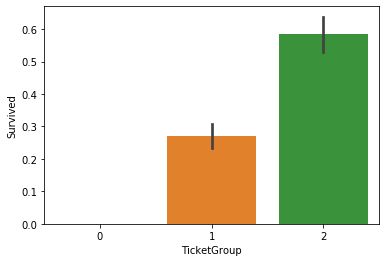

In [44]:
def Ticket_Label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0

all_data['TicketGroup'] = all_data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup', y='Survived', data=all_data)

## 3.数据清洗

#### 1)缺失值填充  
Age Feature：Age缺失量为263，缺失量较大，用Sex, Title, Pclass三个特征构建随机森林模型，填充年龄缺失值。

In [45]:
from sklearn.ensemble import RandomForestRegressor
age_df = all_data[['Age', 'Pclass','Sex','Title']]
age_df=pd.get_dummies(age_df)
known_age = age_df[age_df.Age.notnull()].as_matrix()
unknown_age = age_df[age_df.Age.isnull()].as_matrix()
y = known_age[:, 0]
X = known_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age[:, 1::])
all_data.loc[ (all_data.Age.isnull()), 'Age' ] = predictedAges 

Embarked Feature：Embarked缺失量为2，缺失Embarked信息的乘客的Pclass均为1，且Fare均为80，因为Embarked为C且Pclass为1的乘客的Fare中位数为80，所以缺失值填充为C。

In [46]:
all_data[all_data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Deck,TicketGroup
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,1,1,B,2
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,1,1,B,2


In [48]:
all_data.groupby(by=["Pclass","Embarked"]).Fare.median()

Pclass  Embarked
1       C           76.7292
        Q           90.0000
        S           52.0000
2       C           15.3146
        Q           12.3500
        S           15.3750
3       C            7.8958
        Q            7.7500
        S            8.0500
Name: Fare, dtype: float64

In [49]:
all_data['Embarked'] = all_data['Embarked'].fillna('C')

Fare Feature：Fare缺失量为1，缺失Fare信息的乘客的  
Embarked为S，Pclass为3，所以用Embarked为S，Pclass为3的乘客的Fare中位数填充。

In [50]:
all_data[all_data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Deck,TicketGroup
1043,60.5,Unknown,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr,1,1,U,1


In [51]:
fare=all_data[(all_data['Embarked'] == "S") & (all_data['Pclass'] == 3)].Fare.median()
all_data['Fare']=all_data['Fare'].fillna(fare)

#### 2)同组识别  
把姓氏相同的乘客划分为同一组，从人数大于一的组中分别提取出每组的妇女儿童和成年男性。

In [53]:
all_data['Surname']=all_data['Name'].apply(lambda x:x.split(',')[0].strip())
Surname_Count = dict(all_data['Surname'].value_counts())
all_data['FamilyGroup'] = all_data['Surname'].apply(lambda x:Surname_Count[x])
Female_Child_Group=all_data.loc[(all_data['FamilyGroup']>=2) & ((all_data['Age']<=12) | (all_data['Sex']=='female'))]
Male_Adult_Group=all_data.loc[(all_data['FamilyGroup']>=2) & (all_data['Age']>12) & (all_data['Sex']=='male')]

发现绝大部分女性和儿童组的平均存活率都为1或0，即同组的女性和儿童要么全部幸存，要么全部遇难。

In [54]:
Female_Child=pd.DataFrame(Female_Child_Group.groupby('Surname')['Survived'].mean().value_counts())
Female_Child.columns=['GroupCount']
Female_Child

,GroupCount
1.000000,115
0.000000,31
0.750000,2
0.333333,1
0.142857,1


Text(0.5, 0, 'AverageSurvived')

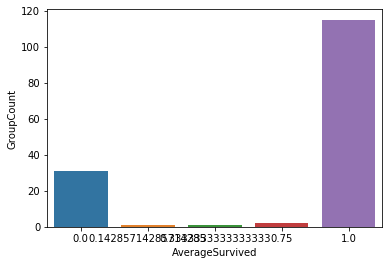

In [55]:
sns.barplot(x=Female_Child.index, y=Female_Child["GroupCount"]).set_xlabel('AverageSurvived')

绝大部分成年男性组的平均存活率也为1或0。

In [57]:
Male_Adult=pd.DataFrame(Male_Adult_Group.groupby('Surname')['Survived'].mean().value_counts())
Male_Adult.columns=['GroupCount']
Male_Adult

,GroupCount
0.000000,122
1.000000,20
0.500000,6
0.333333,2
0.250000,1


因为普遍规律是女性和儿童幸存率高，成年男性幸存较低，所以我们把不符合普遍规律的反常组选出来单独处理。把女性和儿童组中幸存率为0的组设置为遇难组，把成年男性组中存活率为1的设置为幸存组，推测处于遇难组的女性和儿童幸存的可能性较低，处于幸存组的成年男性幸存的可能性较高。

In [58]:
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
Dead_List=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
print(Dead_List)
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
Survived_List=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)
print(Survived_List)

{'Boulos', 'Goodwin', 'Attalah', 'Vander Planke', 'Robins', 'Olsson', 'Sage', 'Lefebre', 'Ford', 'Barbara', 'Turpin', 'Panula', 'Strom', 'Ilmakangas', 'Jussila', 'Oreskovic', 'Skoog', 'Rice', 'Zabour', 'Van Impe', 'Canavan', 'Arnold-Franchi', 'Cacic', 'Caram', 'Bourke', 'Lobb', 'Lahtinen', 'Palsson', 'Johnston', 'Danbom', 'Rosblom'}
{'Jonsson', 'Daly', 'Duff Gordon', 'Beckwith', 'Dick', 'Harder', 'Jussila', 'Goldenberg', 'Nakid', 'Taylor', 'Bradley', 'Beane', 'McCoy', 'Frauenthal', 'Frolicher-Stehli', 'Kimball', 'Chambers', 'Cardeza', 'Bishop', 'Greenfield'}


为了使处于这两种反常组中的样本能够被正确分类，对测试集中处于反常组中的样本的Age，Title，Sex进行惩罚修改。

In [59]:
train=all_data.loc[all_data['Survived'].notnull()]
test=all_data.loc[all_data['Survived'].isnull()]
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Sex'] = 'male'
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Age'] = 60
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Title'] = 'Mr'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Sex'] = 'female'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Age'] = 5
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Title'] = 'Miss'

#### 3)特征转换  
选取特征，转换为数值变量，划分训练集和测试集。

In [60]:
all_data=pd.concat([train, test])
all_data=all_data[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','FamilyLabel','Deck','TicketGroup']]
all_data=pd.get_dummies(all_data)
train=all_data[all_data['Survived'].notnull()]
test=all_data[all_data['Survived'].isnull()].drop('Survived',axis=1)
X = train.as_matrix()[:,1:]
y = train.as_matrix()[:,0]

## 4.建模和优化

### 1)参数优化  

用网格搜索自动化选取最优参数，事实上我用网格搜索得到的最优参数是n_estimators = 28，max_depth = 6。但是参考另一篇Kernel把参数改为n_estimators = 26，max_depth = 6之后交叉验证分数和kaggle评分都有略微提升。

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest

pipe=Pipeline([('select',SelectKBest(k=20)), 
               ('classify', RandomForestClassifier(random_state = 10, max_features = 'sqrt'))])

param_test = {'classify__n_estimators':list(range(20,50,2)), 
              'classify__max_depth':list(range(3,60,3))}
gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='roc_auc', cv=10)
gsearch.fit(X,y)
print(gsearch.best_params_, gsearch.best_score_)

{'classify__max_depth': 6, 'classify__n_estimators': 48} 0.8793119995472937


### 2)训练模型

In [76]:
from sklearn.pipeline import make_pipeline
select = SelectKBest(k = 20)
clf = RandomForestClassifier(random_state = 10, warm_start = True, 
                                  n_estimators = 26,
                                  max_depth = 6, 
                                  max_features = 'sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=20,
                             score_func=<function f_classif at 0x7f41383d3620>)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=6, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=26, n_jobs=None,
                                        oob_score=False, random_state=10,
                                        verbose=0, warm_st

### 3)交叉验证

[input]:  
from sklearn import cross_validation, metrics  
cv_score = cross_validation.cross_val_score(pipeline, X, y, cv= 10)  
print("CV Score : Mean - %.7g | Std - %.7g " % (np.mean(cv_score), np.std(cv_score)))  
  
[Output]:
CV Score : Mean - 0.8451402 | Std - 0.03276752   

## 5.预测

predictions = pipeline.predict(test)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("/opt/submission1.csv", index=False)